In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import CNNClassifier

In [24]:
prm_list = [
    # beta, file_name,
    [0.90, "conf/L32b090_"],
    [0.85, "conf/L32b085_"],

    [0.80, "conf/L32b080_"],
    [0.70, "conf/L32b070_"],

    [0.65, "conf/L32b065_"],
    [0.60, "conf/L32b060_"],

    [0.55, "conf/L32b055_"],
    [0.50, "conf/L32b050_"],

    [0.47, "conf/L32b047_"],
    [0.42, "conf/L32b042_"],

    [0.40, "conf/L32b040_"],
    [0.35, "conf/L32b035_"],

    [0.30, "conf/L32b030_"],
    [0.25, "conf/L32b025_"],

    [0.20, "conf/L32b020_"],
    [0.15, "conf/L32b015_"],

    [0.10, "conf/L32b010_"],
    [0.05, "conf/L32b005_"],

    [0.00, "conf/L32b000_"]
]
# beta19 x conf100 = 1900 data

beta = 090


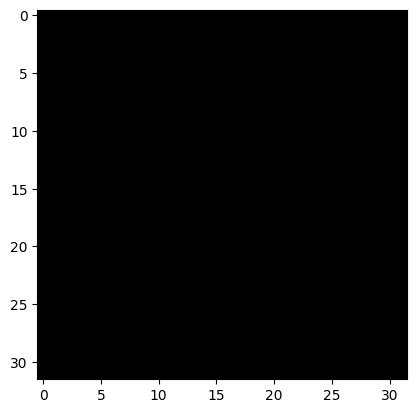

beta = 090


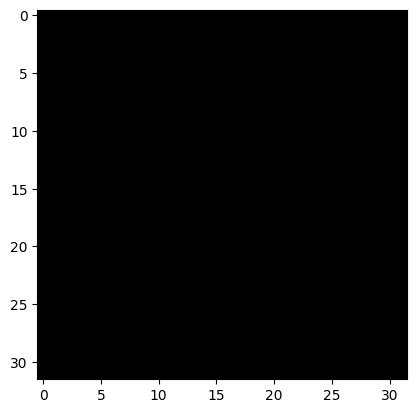

beta = 040


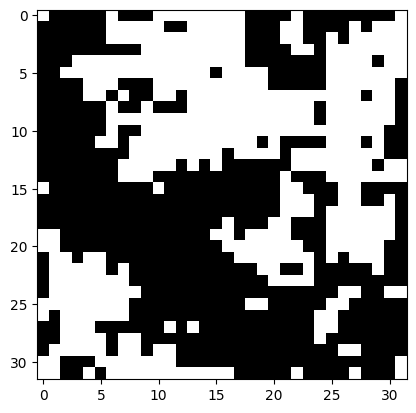

beta = 040


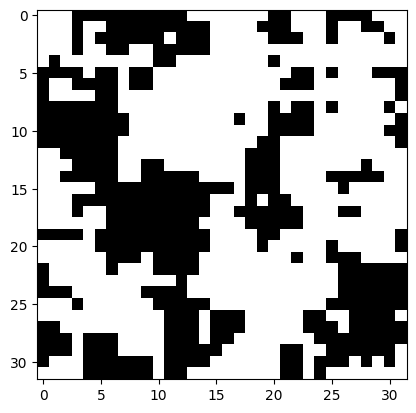

beta = 000


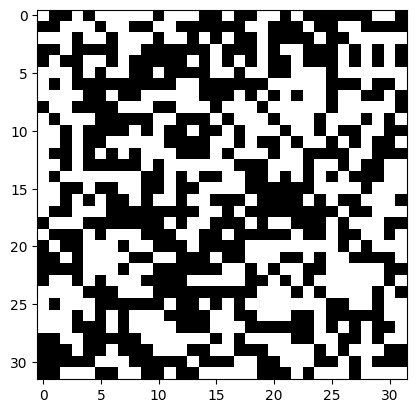

beta = 000


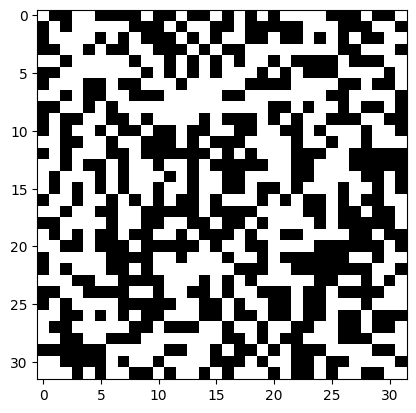

In [25]:
for beta in ["090", "040", "000"]:
    for iconf in range(2):
        print("beta =", beta)
        file = f"conf/L32b{beta}_{iconf}.npy"
        sc = np.load(file)
        plt.imshow(sc, cmap='gray')
        plt.show()

In [26]:
nconf = 100  # The number of configurations per beta
betacr = 0.440686  # critical temp for 2d ising

data = []
labels = []
betas = []
nprm = len(prm_list)
for ibeta in range(nprm):
    beta = prm_list[ibeta][0]
    fname = prm_list[ibeta][1]
    for itrj in range(nconf):
        npsc = np.load(f"{fname}{itrj}.npy")
        data.append(npsc)
        if beta > betacr:
            labels.append(1)
        else:
            labels.append(0)
        betas.append(beta)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.float32)
train_data = data[0::2]
train_labels = labels[0::2]
train_betas = betas[0::2]
val_data = data[1::2]
val_labels = labels[1::2]
val_betas = betas[1::2]

In [27]:
print("train_data.shape = ", train_data.shape)
print("train_labels.shape = ", train_labels.shape)
print("val_data.shape = ", val_data.shape)

train_data.shape =  torch.Size([950, 1, 32, 32])
train_labels.shape =  torch.Size([950])
val_data.shape =  torch.Size([950, 1, 32, 32])


In [28]:
train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=10, shuffle=True)
valid_loader = DataLoader(TensorDataset(val_data, val_labels), batch_size=10, shuffle=False)

In [29]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [30]:
def train(model, train_loader, valid_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target.type(torch.long))
            loss.backward()
            optimizer.step()
        
        model.eval()
        valid_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                valid_loss += criterion(output, target.type(torch.long)).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss /= len(valid_loader.dataset)
        print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {100. * correct / len(valid_loader.dataset)}%')
    print("done.")

train(model, train_loader, valid_loader, criterion, optimizer, epochs=10)
torch.save(model, "2d_Ising_model_classifier.pth")

Epoch: 1, Validation loss: 0.0012958122354076338, Accuracy: 99.78947368421052%
Epoch: 2, Validation loss: 0.0011970853168853143, Accuracy: 99.57894736842105%
Epoch: 3, Validation loss: 0.0014898583164218405, Accuracy: 99.47368421052632%
Epoch: 4, Validation loss: 0.0007000542800665842, Accuracy: 99.78947368421052%
Epoch: 5, Validation loss: 0.008726753514002776, Accuracy: 97.89473684210526%
Epoch: 6, Validation loss: 0.001001606245159547, Accuracy: 99.78947368421052%
Epoch: 7, Validation loss: 0.00011309750819198652, Accuracy: 100.0%
Epoch: 8, Validation loss: 0.010998751012808306, Accuracy: 98.42105263157895%
Epoch: 9, Validation loss: 0.016999171489407768, Accuracy: 99.57894736842105%
Epoch: 10, Validation loss: 0.0168558584124242, Accuracy: 98.73684210526316%
done.


0.9 1.0 0.0
0.85 1.0 0.0
0.8 1.0 0.0
0.7 1.0 0.0
0.65 1.0 0.0
0.6 1.0 0.0
0.55 1.0 0.0
0.5 0.98 0.020000000000000018
0.47 0.8 0.19999999999999996
0.42 0.0 1.0
0.4 0.02 0.98
0.35 0.0 1.0
0.3 0.0 1.0
0.25 0.0 1.0
0.2 0.0 1.0
0.15 0.0 1.0
0.1 0.0 1.0
0.05 0.0 1.0
0.0 0.0 1.0


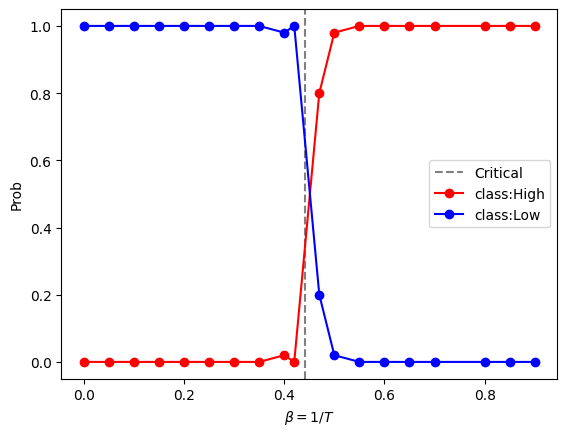

In [31]:
xs = []
y1s = []
y2s = []
Ndatamax = 950
Nsameclass = 50
for j in range(0, Ndatamax, Nsameclass):
    result = model(val_data[j:j+Nsameclass])
    x = val_betas[j]
    y1 = np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    y2 = 1 - np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    print(x, y1, y2)
plt.axvline(x=0.440686, ymin=0, ymax=1, ls="dashed", color="gray", label="Critical")
plt.plot(xs, y1s, label="class:High", marker="o", color="red")
plt.plot(xs, y2s, label="class:Low", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$\beta=1/T$")
plt.ylabel(r"Prob")
plt.show()